Experimenting with multi-agent networks

In [58]:
## Imports
## System imports
import os
import sys

## Add root directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

## LangChain
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent, ToolNode, tools_condition
from langchain import hub
from langchain_core.tools import tool

## Python packages
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
from pprint import pprint 
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from IPython.display import Image, display
import functools

load_dotenv()
assert os.environ["LANGCHAIN_API_KEY"], "Please set the LANGCHAIN_API_KEY environment variable"
assert os.environ["OPENAI_API_KEY"], "Please set the OPENAI_API_KEY environment variable"

## Self-defined modules
from utils import calculations
from prompts import dashboard_prompts

In [59]:
openai_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.environ["OPENAI_API_KEY"])
DATA_DIR = "../../../data"
image_path = DATA_DIR + "/processed/anomaly_detection_sample.png"

In [60]:
## Function for creating an agent
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                """
                You are a helpful AI assistant, collaborating with other assistants.
                Use the provided tools to progress towards answering the question.
                If you are unable to fully answer, that's OK, another assistant with different tools 
                will help where you left off. Execute what you can to make progress.
                If you or any of the other assistants have the final answer or deliverable,
                prefix your response with FINAL_ANSWER so the team knows to stop.
                You have access to the following tools: {tool_names}.
                {system_message}
                """
            ),
            MessagesPlaceholder(variable_name="messages")
        ]
    )

    prompt.partial(system_message=system_message)
    prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(tools)


## Function for creating a chatbot with no tool-calling capabilities
def create_chatbot(llm, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                """
                You are a helpful AI assistant, collaborating with other assistants.
                You are tasked to respond to generic questions by the user, eg. greetings.
                If you cannot fully answer a question or need further information, that's OK, 
                respond as if you are telling the other assistants what the user wants.
                If you or any of the other assistants have the final answer or deliverable,
                prefix your response with FINAL_ANSWER so the team knows to stop.
                ------
                These are what the other assistants are capable of:
                {system_message}
                ------
                Here is an example interaction:
                User: Hi, how are you?
                You: FINAL_ANSWER: I am doing well, thank you for asking.
                User: What is the capital of France?
                You: FINAL_ANSWER: Paris
                User: Most hardworking traders.
                You: I will need more information to answer that question. To the assistants: The user asks, "Most hardworking traders"
                The assistants will then takeover from there.
                """
            ),
            MessagesPlaceholder(variable_name="messages")
        ]
    )

    prompt.partial(system_message=system_message)

    return prompt | llm

In [61]:
## State to be passed between nodes (agents and tools)
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    sender: str ## Tracks most recent sender


## Function for creating nodes of agents
def agent_node(state: State, agent, name):
    result = agent.invoke(state)
    
    ## Format output to a suitable format to be appended to state (unless it is a tool message)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)

    output = {
        "messages": [result],
        "sender": name
    }
    
    return output


## Function for creating nodes without tool-calling
def basic_node(state: State, runnable, name):
    result = runnable.invoke(state["messages"])
    result.name = name

    output = {
        "messages": [result],
        "sender": name
    }
    
    return output

In [62]:
## Create agents
sqlite_db_path = DATA_DIR + "/raw/orders.db"
db = SQLDatabase.from_uri(f"sqlite:///{sqlite_db_path}")
sql_toolkit = SQLDatabaseToolkit(db=db, llm=openai_llm)
sql_tools = sql_toolkit.get_tools()

sql_agent = create_agent(
    openai_llm, 
    sql_tools,
    system_message=hub.pull("langchain-ai/sql-agent-system-prompt").format(dialect="SQLite", top_k=5)
)

## Create a partial function pre-filled with SQL agent details that accepts state as input
sql_node = functools.partial(
    agent_node, 
    agent=sql_agent,
    name="sql_agent"
)

## Create chatbot
chatbot = create_chatbot(
    openai_llm,
    system_message="""
        1. SQL assistant interacts with a database of financial information.
    """
)

## Create a basic agent. Needs to be created this way to ensure state format is consistent
chatbot_node = functools.partial(
    basic_node,
    runnable=chatbot,
    name="chatbot"
)

In [63]:
## Define tool node
tools = sql_tools ## Full list of all tools needed by multi-agent network

tool_node = ToolNode(tools)

In [64]:
## Define router with logic to handle tool-calling and ending
def router(state):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "call_tool"
    elif "FINAL_ANSWER" in last_message.content:
        return END
    return "continue"


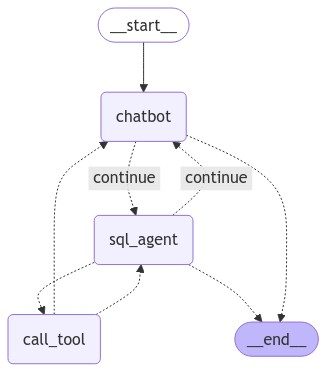

In [65]:
## Create graph
workflow = StateGraph(State)
workflow.add_node("sql_agent", sql_node)
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("call_tool", tool_node)

## Agent nodes go to router
workflow.add_conditional_edges(
    "sql_agent", 
    router, 
    {"continue": "chatbot", "call_tool": "call_tool", END: END} ## Path map that maps router output to node names
)
workflow.add_conditional_edges(
    "chatbot", 
    router, 
    {"continue": "sql_agent", END: END} ## Path map that maps router output to node names
)
## Tool node routes back to the agent that called it, ie the sender
workflow.add_conditional_edges(
    "call_tool",
    lambda state: state["sender"],
    {"chatbot": "chatbot", "sql_agent": "sql_agent"}
)
workflow.add_edge(START, "chatbot")

graph = workflow.compile()

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [66]:
## Run the graph
def stream_graph_updates(graph, user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print(value["messages"][-1].content)

def invoke_graph(graph, user_input: str):
    result = graph.invoke({"messages": [("user", user_input)]})
    print(result["messages"][-1].content)

In [67]:
# stream_graph_updates(graph, "What is the total number of orders?")

In [68]:
# invoke_graph(graph, "Top 5 securities with the highest volume., as well as their respective average prices.")
async for event in graph.astream({"messages": [("user", "Top 5 securities by total volume.")]}):
    print(event)

print("\n\n")

async for event in graph.astream({"messages": [("user", "Hello.")]}):
    print(event)

{'chatbot': {'messages': [AIMessage(content='I will need more information to answer that question. To the assistants: The user asks for "Top 5 securities by total volume." Please clarify if they are looking for a specific market, time period, or type of securities (stocks, ETFs, etc.).', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 231, 'total_tokens': 283, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, name='chatbot', id='run-8e42d0a6-c1c8-46f7-a365-4366335a1c9f-0', usage_metadata={'input_tokens': 231, 'output_tokens': 52, 'total_tokens': 283, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})], 'sender': 'chatbot'}}
{'sql_agent': {'messages': [AIMessage(content='',